In [1]:
import sys
sys.path.append('./Tiny_Faces_in_Tensorflow/')
import tiny_face_eval as tiny
from metrics import *
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error as mse
import glob
import os
import cv2
import pandas as pd
from sklearn.svm import SVC
import numpy as np
import imp
import time
import random
import detect
import dlib
from imgaug import augmenters as iaa
imp.reload(tiny)
imp.reload(detect)
%matplotlib inline

### Streaming videos and saving pictures

In [2]:
cap = cv2.VideoCapture('/home/alexattia/Work/RecVis/famvk.avi')
fps = cap.get(cv2.CAP_PROP_FPS)
initial_target = int(45 * fps) + 10
targets = [initial_target, initial_target+1, initial_target+2, initial_target + 15]
i = 0
frames = []
while(True):
    ret, frame = cap.read()
    i +=1 
    if i in targets:
        frames.append(frame[:,:,::-1])
    if i == targets[::-1][0]:
        break

### Detections in the first and last pictures

In [3]:
weights_path = './Tiny_Faces_in_Tensorflow/hr_res101.pkl'

In [4]:
detections = []
for frame in [frames[0], frames[::-1][0]]:
    with tf.Graph().as_default():
        b = tiny.evaluate(weight_file_path=weights_path, data_dir='.jpg', output_dir='', framee=frame,
                          prob_thresh=0.5, nms_thresh=0.1, lw=3, 
                          display=False, save=False, draw=False, print_=0)
    detections.append(b[0])

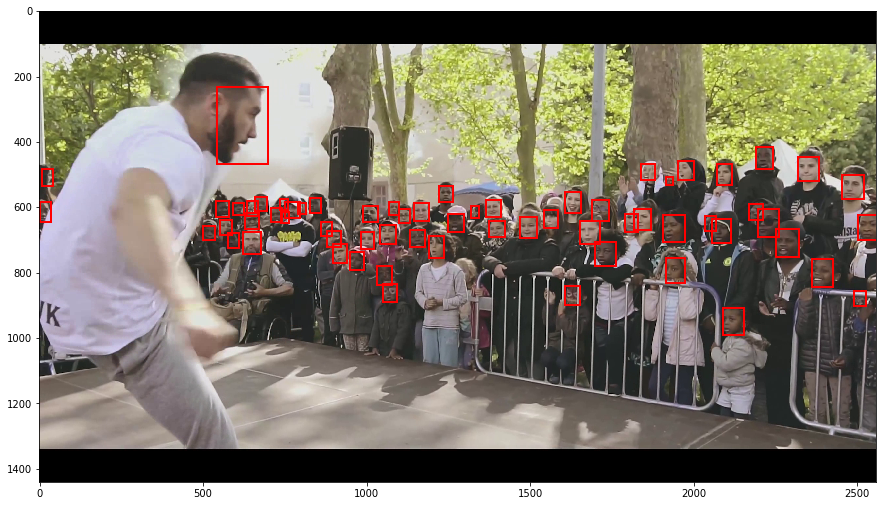

In [10]:
f, ax = plt.subplots(figsize=(15,10))
ax.imshow(frames[0])
# plot the predicted bounding boxes
for k in detections[0]:
    x1, y1 = k[:2]
    w, h = k[2] - k[0], k[3] - k[1]
    rect = patches.Rectangle((x1,y1),w, h,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [11]:
face_encoder = dlib.face_recognition_model_v1('./model/dlib_face_recognition_resnet_model_v1.dat')
face_pose_predictor = dlib.shape_predictor('./model/shape_predictor_68_face_landmarks.dat')

### One classifier = One person from frame 0

**Check that the detection has moved between frame 0 and frame 15**

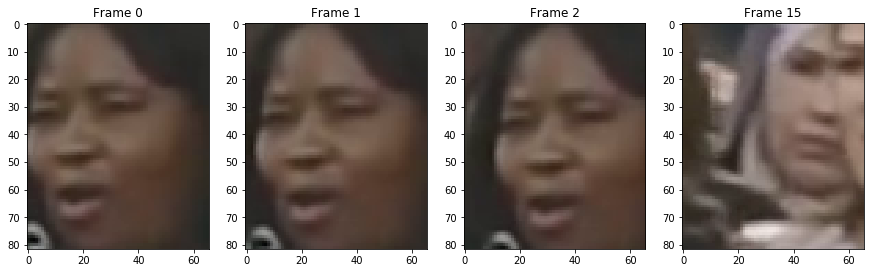

In [12]:
idx_detection = 10
# Using coordinates detection of one personne over 3 consecutives frame
f,ax = plt.subplots(ncols=4, figsize=(15,15))
# idx_detection-th detection of the first pictures
x1, y1, x2, y2 = detections[0][idx_detection]
# We use the coordinates of this detection on the two following frames
for j in range(4):
    img = frames[j][y1:y2,x1:x2,:]
    ax[j].imshow(img)
    ax[j].set_title('Frame %d' % (j if j != 3 else 15))
## --> It moves between frame (target + 2) and (target + 15)

**Finding the matching people between frame 0 and frame 15**

In [13]:
# neigh_detect: detections in the neighborood of the face in the first frame
# distances : SVM distance/proba to be the same face for these detections
imp.reload(detect)
neigh_detect, distances = detect.train_binclas(frames, detections, idx_detection)

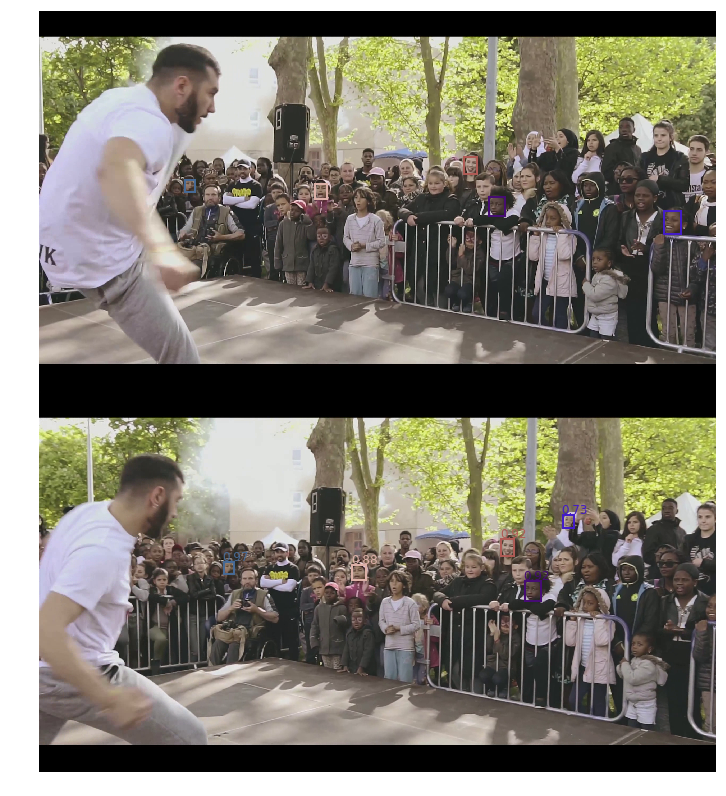

In [16]:
f, axes = plt.subplots(nrows=2, figsize=(14,14), gridspec_kw = {'wspace':0, 'hspace':0}) 
indices = np.random.randint(0, 20, 5)
axes[0].imshow(frames[0])
axes[1].imshow(frames[3])
axes[1].axis('off')
axes[0].axis('off')
for p in indices:
    neigh_detect, distances = detect.train_binclas(frames, detections, p)
    idx_max, val_max = np.argmax(distances[:,1]), np.max(distances[:,1])
    x1_, y1_, x2_, y2_ = neigh_detect[idx_max]
    w_, h_ = x2_ - x1_, y2_ - y1_
    color = np.random.rand(3)
    rect = patches.Rectangle((x1_,y1_), w_, h_, linewidth=2, edgecolor=color,facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(x1_-5, y1_ -5, '%.2f' % val_max, fontsize=12, color=color)
    
    x1, y1, x2, y2 = detections[0][p]
    w, h = x2 - x1, y2 - y1
    rect = patches.Rectangle((x1,y1), w, h, linewidth=2,edgecolor=color,facecolor='none')
    axes[0].add_patch(rect)

In [38]:
## TODO : Jaccard between two same face

#### Annotation to get the threshold for classification

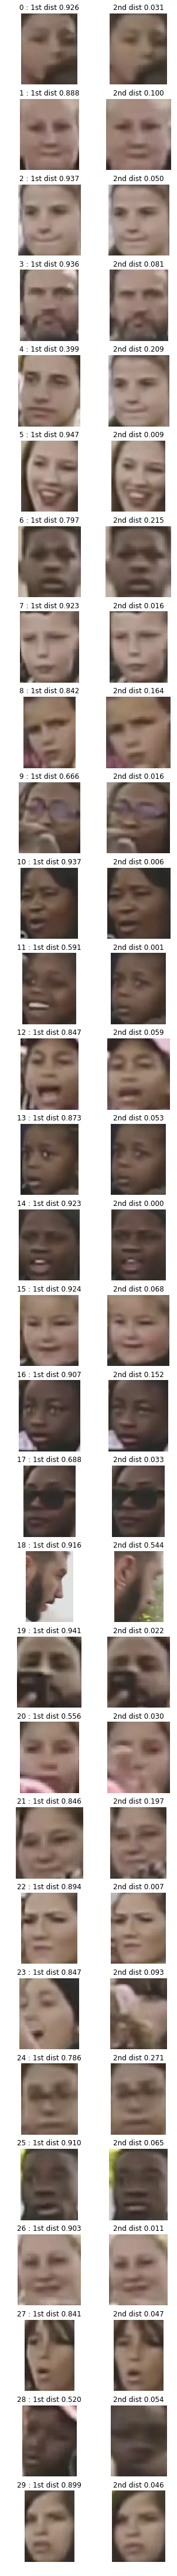

In [18]:
## Annotation
f, axes = plt.subplots(ncols=2, nrows=30, figsize=(5,80))
annotate = []
for p in range(30):
    # p <-> idx_detection <-> idx in detections[0]/frames[0]
    neigh_detect, distances = detect.train_binclas(frames, detections, p)
    idx_max, val_max = np.argmax(distances[:,1]), np.max(distances[:,1])
    annotate.append([p, val_max, distances[:,1][::-1][1], True])
    x1_, y1_, x2_, y2_ = neigh_detect[idx_max]
    x1, y1, x2, y2 = detections[0][p]
    img_truth = frames[0][y1:y2,x1:x2,:]
    img_pred = frames[3][y1_:y2_,x1_:x2_,:]
    axes[p,0].imshow(img_truth)
    axes[p,1].imshow(img_pred)
    axes[p,1].axis('off')
    axes[p,0].axis('off')
    axes[p,0].set_title('%d : 1st dist %.3f' % (p, val_max))
    axes[p,1].set_title('2nd dist %.3f' % distances[:,1][::-1][1])

In [20]:
# Using manual verification
df = pd.DataFrame(annotate)
df.columns = ['idx', 'Max Dist', "2nd Max Dist", "Pred"]
idx_out_picture = [4.0, 11.0, 23.0, 28.0]
df.loc[df['idx'].isin(idx_out_picture), 'Pred'] = 0
df['Diff'] = df['Max Dist'] - df['2nd Max Dist']

In [21]:
def f_beta_score(precision, recall, beta=1):
    temp = (precision*recall)/((beta**2 * precision) + recall)
    return (1+beta**2)*temp

Best Threshold for Maximum Score 0.60 with Precision 0.96 and Recall 0.96
Best Threshold for Diff Max Score 0.76 with Precision 1.00 and Recall 0.65


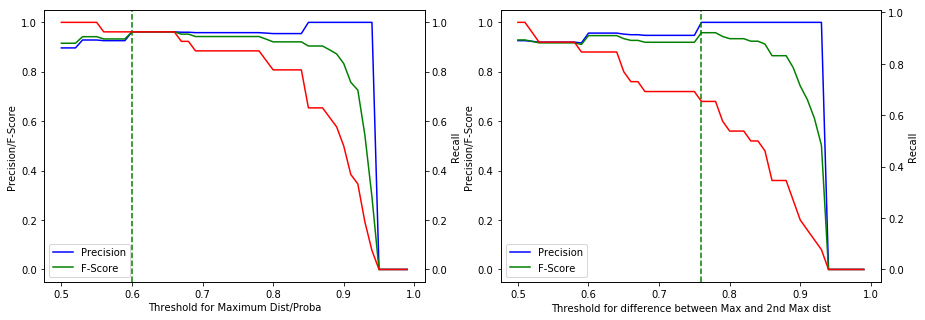

In [22]:
precisions, recalls, f_score = [],[],[]
# Threshold for MaxDist
x = [k*0.01 for k in range(50,100)]
for th in x:
    true_pos = len(df[(df['Max Dist']>th) & (df['Pred'] == 1)])
    false_pos = len(df[(df['Max Dist']>th) & (df['Pred'] == 0)])
    false_neg = len(df[(df['Max Dist']<th) & (df['Pred'] == 1)])
    try:
        precision = true_pos/(true_pos+false_pos)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = true_pos/(true_pos+false_neg)
    except ZeroDivisionError:
        recall = 0
    precisions.append(precision)
    recalls.append(recall)
    try:
        f_score.append(f_beta_score(precision, recall, 0.5))  
    except ZeroDivisionError:
        f_score.append(0)
        
f, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(x, precisions, 'b', label='Precision')
ax[0].plot(x, f_score, 'g', label='F-Score')
ax[0].set_xlabel('Threshold for Maximum Dist/Proba')
ax[0].set_ylabel('Precision/F-Score')
ax[0].axvline(x=x[np.argmax(f_score)], color='g', linestyle='--')
ax1 = ax[0].twinx()
ax1.plot(x, recalls, 'r', label='Recall')
ax1.set_ylabel('Recall')
ax[0].legend()
print('Best Threshold for Maximum Score %.2f with \
Precision %.2f and Recall %.2f' % (x[np.argmax(f_score)], 
                                   precisions[np.argmax(f_score)], 
                                   recalls[np.argmax(f_score)]))

# Theshold for difference between Max and 2nd Max dist
precisions, recalls, f_score = [],[],[]
for th in x:
    true_pos = len(df[(df['Diff']>th) & (df['Pred'] == 1)])
    false_pos = len(df[(df['Diff']>th) & (df['Pred'] == 0)])
    false_neg = len(df[(df['Diff']<th) & (df['Pred'] == 1)])
    try:
        precision = true_pos/(true_pos+false_pos)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = true_pos/(true_pos+false_neg)
    except ZeroDivisionError:
        recall = 0
    precisions.append(precision)
    recalls.append(recall)
    try:
        f_score.append(f_beta_score(precision, recall, 0.3))  
    except ZeroDivisionError:
        f_score.append(0)
    
ax[1].plot(x, precisions, 'b', label='Precision')
ax[1].plot(x, f_score, 'g', label='F-Score')
ax[1].set_xlabel('Threshold for difference between Max and 2nd Max dist')
ax[1].set_ylabel('Precision/F-Score')
ax[1].axvline(x=x[np.argmax(f_score)], color='g', linestyle='--')
ax2 = ax[1].twinx()
ax2.plot(x, recalls, 'r')
ax2.set_ylabel('Recall')
ax[1].legend()
print('Best Threshold for Diff Max Score %.2f with \
Precision %.2f and Recall %.2f' % (x[np.argmax(f_score)], 
                                   precisions[np.argmax(f_score)], 
                                   recalls[np.argmax(f_score)]))

#### Counting faces between two frames

In [27]:
threshold = 0.6

In [33]:
matched = 0
for p in range(len(detections[0])):
    neigh_detect, distances = detect.train_binclas(frames, detections, p)
    idx_max, val_max = np.argmax(distances[:,1]), np.max(distances[:,1])
    if idx_max > threshold:
        matched += 1

In [34]:
matched

60

In [36]:
len(detections[0]) + len(detections[1]) - matched

73

### One classifier for all faces from frame 0

In [189]:
imp.reload(detect)
df = pd.DataFrame()
for idx in range(20):
    df = pd.concat([df, detect.create_positive_set(pics, detections[0][idx], idx)])
df = df.sample(len(df)).reset_index(drop=True)
# Train sets
y = df[128]
X = df.drop(128, axis=1)
# training
clf = SVC(C=1, kernel='linear', probability=True)
_= clf.fit(X, y)

In [190]:
# keeping 4th picture detections in the neighborhoud
neigh_detect = [k for k in detections[3] if 
                np.abs(k[0]-x1) < 600 and 
                np.abs(k[1]-y1) < 600 and
                np.abs(k[2]-x2) < 600 and
                np.abs(k[3]-y2) < 600]

# Get face images to classify
img_neighb = [pics[3][y1_:y2_,x1_:x2_,:] for (x1_, y1_, x2_, y2_) in detections[3]]
# Encode each face
neigh_detect_encodings = detect.encoding_faces(img_neighb, -1, neigh_detect)[:,:128]
# compute distances
distances = clf.predict_proba(neigh_detect_encodings)

In [ ]:
f, axes = plt.subplots(ncols=2, nrows=20, figsize=(5,40))
for p in range(20):
    idx_max = np.argmax(distances[:, p])
    val_max = sorted(distances[:, p], reverse=True)[:2]
    x1_, y1_, x2_, y2_ = neigh_detect[idx_max]
    x1, y1, x2, y2 = detections[0][p]
    img_truth = pics[0][y1:y2,x1:x2,:]
    img_pred = pics[3][y1_:y2_,x1_:x2_,:]
    axes[p,0].imshow(img_truth)
    axes[p,1].imshow(img_pred)
    axes[p,1].axis('off')
    axes[p,0].axis('off')
    axes[p,0].set_title('Truth')
    axes[p,1].set_title('1st Max dist %.2f\n2nd Max dist %.2f' % (val_max[0], val_max[1]))